SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #2: Simple Exponential Smoothing Model </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** simple exponential smoothing, adaptive exponential smoothing, retail time series

**Your fitback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [2]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
import pandas as pd
import math
import pandas.tseries.offsets as ofs
import warnings as w
from matplotlib import gridspec
# import plotly.plotly as py
import seaborn as sns

from IPython.display import Image

%matplotlib inline

# Typical TS for SES Model

## TS in Retail

In [3]:
ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_10ts.csv', parse_dates=['Dates'], dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index
ts.head()

Item:  165  Item:  969  ...  Item: 2806  Item: 2808
Timestamp                           ...                        
2005-01-11         NaN         2.0  ...         NaN         NaN
2005-01-12         NaN         5.0  ...         NaN         NaN
2005-01-13         NaN         2.0  ...         NaN         NaN
2005-01-14         NaN        42.0  ...         NaN         NaN
2005-01-15         NaN         NaN  ...         NaN         NaN

[5 rows x 11 columns]

In [4]:
# Interval of ts 
ts.loc['2007-01-01':'2007-01-05']

Item:  165  Item:  969  ...  Item: 2806  Item: 2808
Timestamp                           ...                        
2007-01-01         NaN         NaN  ...         NaN         NaN
2007-01-02         NaN        21.0  ...         3.0         5.0
2007-01-03         NaN        10.0  ...         0.0         2.0
2007-01-04         NaN         NaN  ...         NaN         1.0
2007-01-05         NaN         3.0  ...         4.0         1.0

[5 rows x 11 columns]

**Questions** 
    - Which charachteristic of TS can you mention so far?
    - Which components of TS can you see?

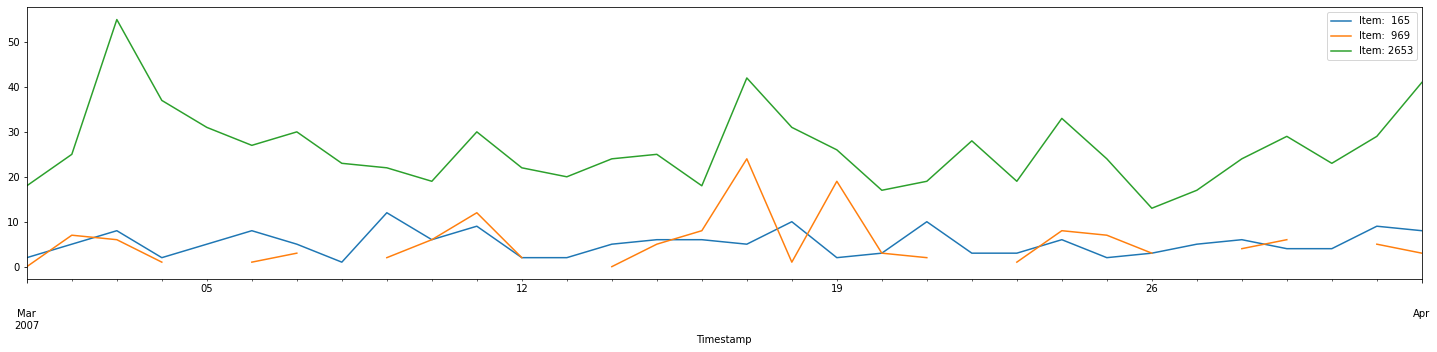

In [5]:
# fig = plt.figure()
ts.loc['2007-03-01':'2007-04-01', ts.columns[range(3)]].plot(figsize=(25,5))
# to save the pictures
# plt.savefig('../Lecture_TS_Forecasting/pic/TS_Example.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

**Questions**

 - What are key aspects of these retail ts?


In [6]:
fig = plt.figure(figsize=(25,10))
gs = gridspec.GridSpec(3, 3)
for i in range(3):
    for j in range(3):
        fig.add_subplot(gs[i,j])
        ts.loc[:, ts.columns[i+j]].plot()

**Questions**

 - Any idea how to predict such ts?
 - Can you describe statistical model for such ts?

###### Answer



$$y_{t} = l_t + \color{red}{\varepsilon_t},$$

where $l_t$ $-$ changing slowly level of time series,

$\varepsilon_t~-$ error component (unobserved noise)

Forecasting model:

$$ {\hat y_{t+d}} = \color{\red}{\hat l_t} $$

where $\hat l_t~-$ an estimation of level


## Moving Average

** Rolling window n **
       $$\hat y_{t+d} = \frac{1}{n}\left(y_{t-n}+\dots+ {y}_t\right)$$
   
** All points in  $[t-n, t]$ has the same weight **
                                   $$w = \frac{1}{n}$$
** Other points has weight**
                                    $$w = 0$$

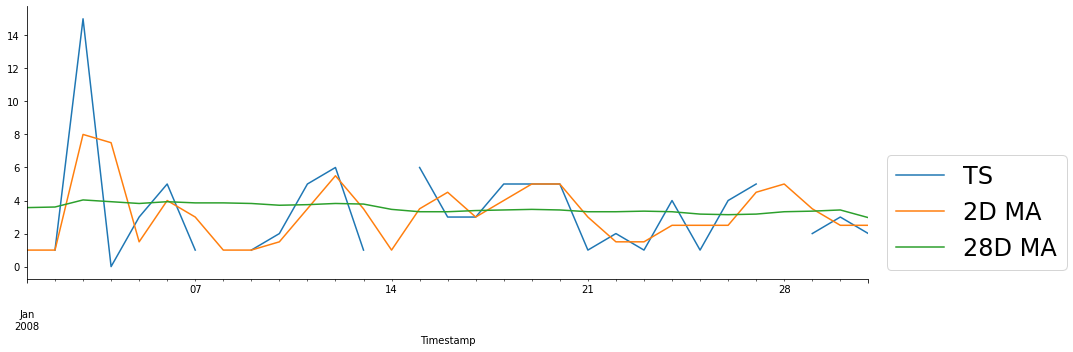

In [7]:
# Rolling moving (n = 2 и n=28)
# Note: replace NaN befor average calculation
ts.loc['2008-01-01':'2008-01-31'][u'Item:  165'].plot(label='TS')
ts[u'Item:  165'].fillna(method='pad').rolling(2).mean().loc['2008-01-01':'2008-01-31'].plot(label='2D MA', figsize=(15,5))
ts[u'Item:  165'].fillna(method='pad').rolling(28).mean().loc['2008-01-01':'2008-01-31'].plot(label='28D MA', figsize=(15,5))

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':24})
plt.tight_layout()
sns.despine()

**Expanding window**
       $$\hat y_{t+d} = \frac{1}{t}\left(y_{1}+\dots+ {y}_t\right)$$
   
**All time points in $[1, t]$ has the same weight**
                                   $$w = \frac{1}{t}$$   

In [8]:
# Expanding windod
ts.loc['2008-01-01':'2008-01-31'][u'Item:  165'].plot(label='TS')
ts.fillna(method='pad')[u'Item:  165'].expanding().mean().loc['2008-01-01':'2008-01-31'].plot(label='Expanding', figsize=(25,5))

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':24})
plt.tight_layout()
sns.despine()

**Questions**

 - What are analytical disadvantages of using movinag average algorithm?


## Exponentially Wighted Moving Average

**Exponentialy diminishing weights**
    $$\hat y_{t+d}= \alpha y_t + \alpha \left(1-\alpha\right)y_{t-1} + \alpha \left(1-\alpha\right)^2y_{t-2}+\dots = \sum_{\tau=1}^t \alpha\cdot (1-\alpha)^{t-\tau}\cdot y_\tau$$
   
**Weight for time point in moment $\tau$**
    $$w_\tau = \alpha\cdot (1-\alpha)^{t-\tau}$$  


In [17]:
# look at timestamp weights
t = 10
alpha_set = [0.001, 0.1, 0.2, 0.5, 0.9]
pd.DataFrame(data = [[a*(1-a)**(t-tau) for a in alpha_set] for tau in range(1,t+1,1)], columns = [r'\alpha=' + str(x) for x in alpha_set], index = range(1,t+1,1)).sort_index(ascending = False)

\alpha=0.001  \alpha=0.1  \alpha=0.2  \alpha=0.5    \alpha=0.9
10      0.001000    0.100000    0.200000    0.500000  9.000000e-01
9       0.000999    0.090000    0.160000    0.250000  9.000000e-02
8       0.000998    0.081000    0.128000    0.125000  9.000000e-03
7       0.000997    0.072900    0.102400    0.062500  9.000000e-04
6       0.000996    0.065610    0.081920    0.031250  9.000000e-05
5       0.000995    0.059049    0.065536    0.015625  9.000000e-06
4       0.000994    0.053144    0.052429    0.007812  9.000000e-07
3       0.000993    0.047830    0.041943    0.003906  9.000000e-08
2       0.000992    0.043047    0.033554    0.001953  9.000000e-09
1       0.000991    0.038742    0.026844    0.000977  9.000000e-10

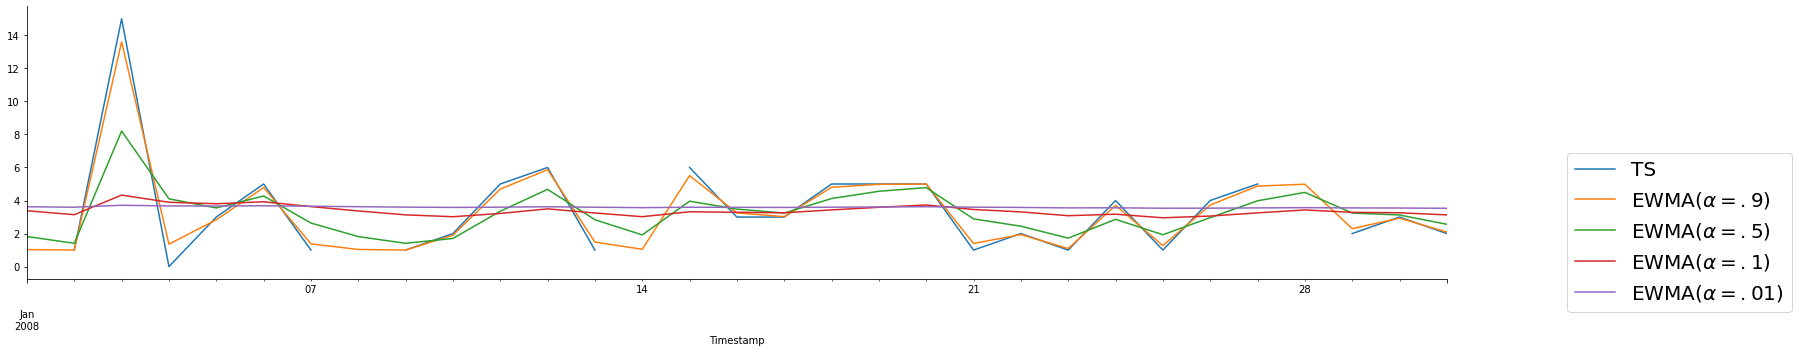

In [11]:
# Averaging with exponential weights
ts.loc['2008-01-01':'2008-01-31'][u'Item:  165'].plot(label='TS')
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.9).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.9$)') 
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.5).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.5$)') 
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.1).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.1$)') 
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.01).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.01$)', figsize=(25,5)) 

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':20})
plt.tight_layout()
sns.despine()

**Parameter $\alpha$ drives the depth of the historical period to be considered!**

$\alpha \uparrow 1 \; \Rightarrow$ EWMA is closer to Moving Average with window = 1,

$\alpha \downarrow 0 \; \Rightarrow$ EWMA is closer to Moving Average with expanding window.

In [18]:
# Compare EWMA (alpha = 0.001) and Expanding 
ts.loc['2008-01-01':'2009-01-10'][u'Item:  165'].plot(label='Raw')
ts[u'Item:  165'].fillna(method='pad').expanding().mean().loc['2008-01-01':'2009-01-10'].plot(label='Expanding')
ts[u'Item:  165'].ewm(alpha=0.001).mean().loc['2008-01-01':'2009-01-10'].plot(label='EWMA($\\alpha=.001$)', figsize=(25,5)) 

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':20})
plt.tight_layout()
sns.despine()

In [19]:
# Compare EWMA (alpha = 0.9) and MA (window = 1) 
# ts.loc['2008-01-01':'2009-01-10'][u'Item:  165'].plot(label='Raw')
ts[u'Item:  165'].fillna(method='pad').rolling(1).mean().loc['2008-01-01':'2009-01-10'].plot(label='MA 1D')
ts[u'Item:  165'].ewm(alpha=0.9).mean().loc['2008-01-01':'2009-01-10'].plot(label='EWMA($\\alpha=.9$)', figsize=(25,5)) 
plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':20})

# Simple Exponential Smoothing Realization

**Sum notation**:
$$\hat{y}_{t+d} = \sum_{\tau=1}^t \alpha\cdot (1-\alpha)^{t-\tau}\cdot y_\tau~~~~~(1)$$ 

**Question:**
 * What is the problem with this formla (1)?
 * Hint: calculate sum of weights of time series points.

**Recurrent formula notation:**
$$\hat{y}_{t+d} = \alpha\cdot y_t+ (1-\alpha)\cdot \hat{y}_t = \hat y_t + \alpha \cdot \color{red}{e_t}$$




In [20]:
# Example of realization

# Simple Exponential Smoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter

def SimpleExponentialSmoothing(x, h=1, Params={}):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(y):
                y=x[cntr]
            y = y*(1-alpha) + alpha*x[cntr]
            #else do not nothing
        FORECAST[cntr+h] = y
    return FORECAST

In [21]:
# Forecast delay = 1
h = 1
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

In [22]:
# ES params
Params ={'alpha':0.1}

# generate forecasts for each Item
for cntr in ts.columns:
    frc_ts[cntr] = SimpleExponentialSmoothing(ts[cntr], h, Params)

In [23]:
# fig = plt.figure(figsize=(25,7))
# ax1=fig.add_subplot(111)
# qlt_array=['SSE', 'MSE', 'RMSE', 'MedianAE', 'MAPE', 'MACAPE']
# for i in range(6):
#     # Quality = [np.NaN]*len(ts.columns)
#     plt.subplot(2,3,i+1)
#     Quality, _ = eval('quality'+qlt_array[i])(ts, frc_ts)
#     Quality.plot(kind='bar')
#     plt.title(qlt_array[i], y=0.9)

In [28]:
# show SES forecast alpha = 0.1
def plotTSForecast(ts, frc_ts, ts_num=0, alg_title=''):
    frc_ts.columns = ts.columns+'; '+alg_title
    ts[ts.columns[0]].plot(style='b', linewidth=1.0, marker='o')
    ax = frc_ts[frc_ts.columns[ts_num]].plot(style='r-^', figsize=(25,5), linewidth=1.0)
    plt.xlabel("Time ticks")
    plt.ylabel("TS values")
    plt.legend()
    return ax

plotTSForecast(ts.loc['2009-01-01':'2009-02-03'], frc_ts.loc['2009-01-01':'2009-02-03'], ts_num=0, alg_title='ES alpha=0.1')

**Question:**
 * Why the forecasts values for 27th, 28th, 29th and 30th of January are the same?
 * When does the last change of the forecast value occur?  

In [29]:
# Generate forecast for h = 30
h = 30
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

for cntr in ts.columns:
    frc_ts[cntr] = SimpleExponentialSmoothing(ts[cntr], h, {'alpha':0.1})

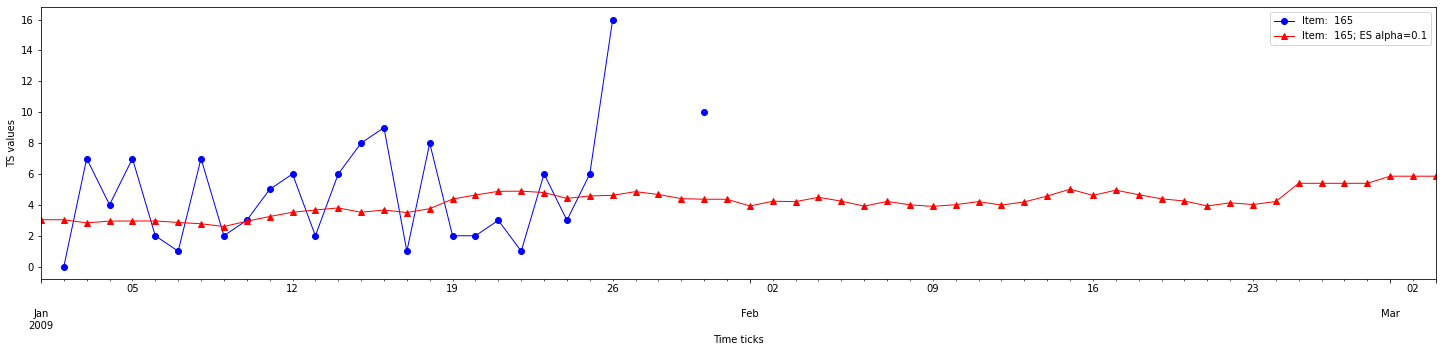

In [30]:
# show forecast h = 30, alpha = 0.1
plotTSForecast(ts.loc['2009-01-01':'2009-03-03'], frc_ts.loc['2009-01-01':'2009-03-03'], ts_num=0, alg_title='ES alpha=0.1')

## Search for the optimal $\alpha$ 

In [26]:
def build_forecast(h, ts, AlgName, AlgTitle, ParamsArray, step='D'):
  'grid'
    
  FRC_TS = dict()

  for p in ParamsArray:
      frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
      frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns)
      
      for cntr in ts.columns:
          frc_ts[cntr] = eval(AlgName)(ts[cntr], h, p)
          # frc_ts[cntr] = AlgName(ts[cntr], h, p)
      
#         frc_ts.columns = frc_ts.columns+('%s %s' % (AlgTitle, p))
      FRC_TS['%s %s' % (AlgTitle, p)] = frc_ts
  
  return FRC_TS

In [27]:
#Fit parameters
ALPHA = [0.7, 0.4, 0.2, .15, 0.1, 0.05, 0.01]
ESParamsArray = [{'alpha':alpha} for alpha in ALPHA]
FRC_TS = build_forecast(h=1, ts=ts, AlgName =  'SimpleExponentialSmoothing', AlgTitle='ES' ,ParamsArray = ESParamsArray)

### Loss of the SES forecast for all history

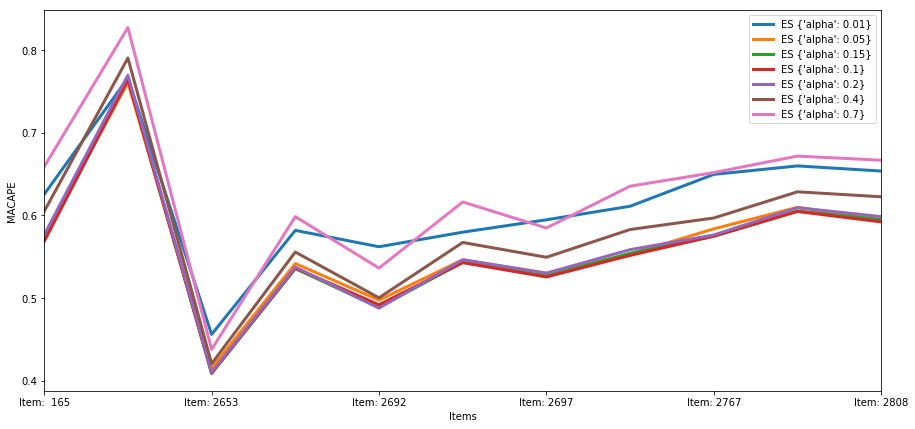

In [ ]:
# compare ES parameters
QualityStr = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality through 1500 steps
ix = ts.index
for param_cntr in sorted(QualityStr.columns):
    frc_ts = FRC_TS[param_cntr]
    QualityStr[param_cntr],_ = qualityMACAPE(ts.loc[ix], frc_ts.loc[ix])

ax = QualityStr[sorted(QualityStr.columns)].plot(figsize = (15,7), linewidth=3.0)
ax.set_xlabel("Items")
ax.set_ylabel("MACAPE")

* The optimal value of $\alpha$ is about $0.1$ 

### Loss for first time series point

In [ ]:
# Quality in first 100 steps
# ix = range(100)
for model in QualityStr.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+timedelta(150))
        QualityStr[model][ts_num],_ = qualityMACAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])

ax = QualityStr[sorted(QualityStr.columns)].plot(figsize = (15,4), linewidth=3.0)
ax.set_xlabel("Items")
ax.set_ylabel("MACAPE")

** Question:**
        Why is loss function  not calculated for some items?
        
        (Hint: see definition of loss function)

### Look at TS №3

In [ ]:
# ts VS forecast in first 100 steps
model_num = [0,4,6]  # [0,6], [0,4,6]
Models = sorted(FRC_TS.keys())

ts_num = 3 # 7
plot_ts = pd.DataFrame(index =ts.index)
plot_ts[ts.columns[ts_num]] = ts[ts.columns[ts_num]]
for model in model_num:
     frc_ts = FRC_TS[Models[model]]
     plot_ts[frc_ts.columns[ts_num]+'; '+Models[model]] = frc_ts[frc_ts.columns[ts_num]]

ix = pd.date_range(ts[ts.columns[ts_num]].first_valid_index()+timedelta(140), ts[ts.columns[ts_num]].first_valid_index()+timedelta(170))
plot_ts.loc[ix].plot(figsize = (15, 7), linewidth=3.0) # :250

** Wow: we need to use big $\alpha$ for first steps of ES!** 
    - We need to modify algorithm for tirst steps!

** Question: **
   How algorithm can be modified for first steps?

### Examples of modification

* First variant: let's make $\alpha$ higher for first time point of TS

In [ ]:
def InitExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    t0=0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + alpha*x[t]
            #else do not nothing
        FORECAST[t+h] = y
    return FORECAST

* Second variant: normalize weights of ES: $1 - (1-\alpha)^t$

In [ ]:
def NormExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    
    y = 0
    norm = 0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                norm=1  # initialize when first data point comes
            norm = norm*(1-alpha)
            y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y/(1-norm)
    return FORECAST

In [ ]:
#Fit parameters

ALPHA = [0.7, 0.4, 0.2, .15, 0.1, 0.05, 0.01]
ESParamsArray = [{'alpha':alpha, 'AdaptationPeriod': 5} for alpha in ALPHA]
FRC_TS.update(build_forecast(h=1, ts=ts, AlgName =  'InitExponentialSmoothing', AlgTitle='IES' ,ParamsArray = ESParamsArray))
FRC_TS.update(build_forecast(h=1, ts=ts, AlgName =  'NormExponentialSmoothing', AlgTitle='NES' ,ParamsArray = ESParamsArray))

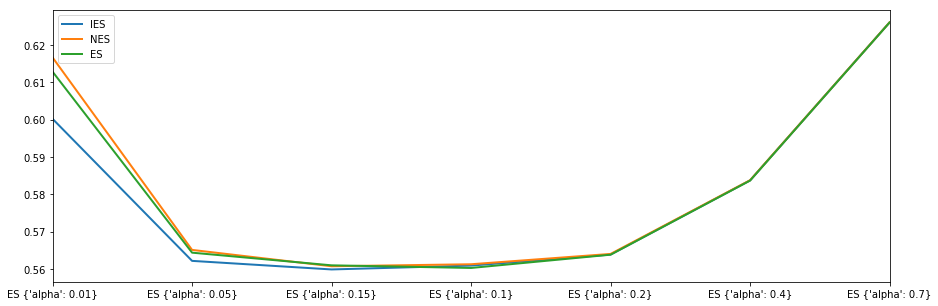

In [ ]:
# compare ES methods
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in sorted(QualityStr.columns):
    frc_ts = FRC_TS[model]
    QualityStr[model],_ = qualityMACAPE(ts, frc_ts)


QualityStr[sorted(QualityStr.columns)[7:14]].mean().plot(label='IES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[14:]].mean().plot(label='NES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[:7]].mean().plot(label='ES', figsize = (15, 5),linewidth=2.0)
# ax.set_xticklabels(np.reshape(np.asarray(QualityStr.columns[:14]), (2, 7)).T , rotation=90)
plt.legend()

* Conclusion: **The optimal value of $\alpha$ is about the same for all ES modifications.**

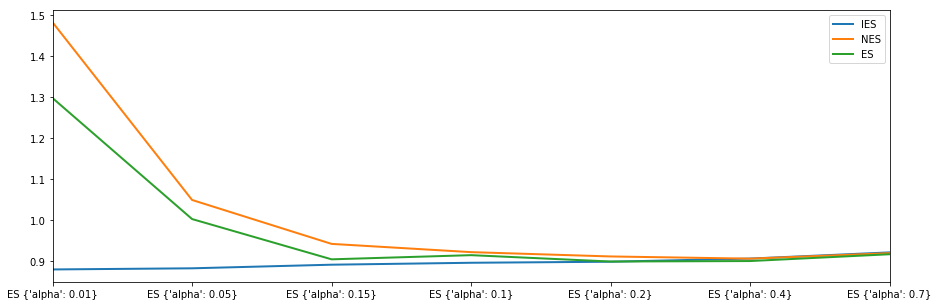

In [ ]:
# compare ES methods in first 100 steps
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in QualityStr.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+timedelta(50))
        QualityStr[model][ts_num],_ = qualityMACAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])


QualityStr[sorted(QualityStr.columns)[7:14]].mean().plot(label='IES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[14:21]].mean().plot(label='NES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[:7]].mean().plot(label='ES',  figsize = (15, 5),linewidth=2.0)
plt.legend()

# Adaptive ES (self-studying)

### Tracking signal

$e_t = y_t - \hat{y}_t$

$\tilde{e}_t = \gamma e_{t-1} + (1-\gamma) \tilde{e}_{t-1}$

$\overline{e}_t = \gamma \left|e_{t-1}\right| + (1-\gamma) \overline{e}_{t-1}$

* Tracking signal

$$K_t = \frac{\tilde{e}_t}{\overline{e}_t}$$

* to do algorithm more stable 
$$\alpha_t = \left|K_{t-1}\right|$$

In [ ]:
# AdaptiveExponentialSmoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    AdaptivePeriod scalar> - adapation period for initialization
#    gamma<scalar in [0,1]> - parametr of cross validation

def AdaptiveExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = np.NaN
    t0= np.NaN
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
                e1=alpha
                e2 = 1
            else:
                if (t-t0)<h:
                    e1 = gamma*(x[t]-y)+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-y)+(1-gamma)*e2
                else:
                    e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            
            if e2==0:
                K=alpha
            else:
                K=np.abs(e1/e2)

            alpha=Kt_1
            Kt_1=K

            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y
    return FORECAST

In [ ]:
#Fit parameters
GAMMA = [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
alpha = 0.1
AESParamsArray = [{'alpha':alpha, 'gamma':gamma, 'AdaptationPeriod': 5} for gamma in GAMMA]
FRC_TS.update(build_forecast(h=1, ts=ts, AlgName =  'AdaptiveExponentialSmoothing', AlgTitle='AES' ,ParamsArray = AESParamsArray))

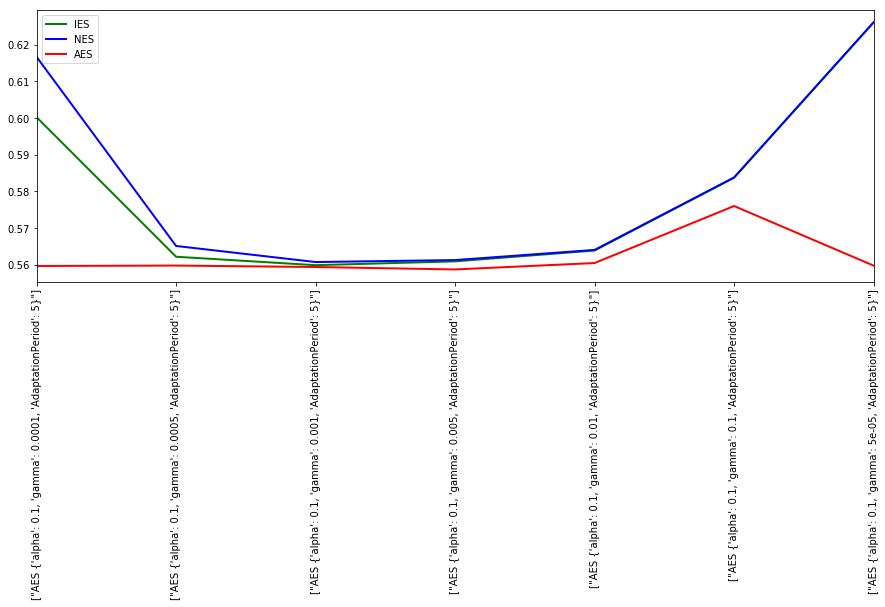

In [ ]:
# compare ES methods
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in sorted(QualityStr.columns):
    frc_ts = FRC_TS[model]
    QualityStr[model],_ = qualityMACAPE(ts, frc_ts)

QualityStr[sorted(QualityStr.columns)[14:21]].mean().plot(color='g', label='IES', figsize = (15, 5), linewidth=2)
QualityStr[sorted(QualityStr.columns)[21:]].mean().plot(color='b', label='NES', linewidth=2 )
ax = QualityStr[sorted(QualityStr.columns)[:7]].mean().plot(color='r', label='AES', linewidth=2 )
ax.set_xticklabels(np.reshape(np.asarray(QualityStr.columns[:7]), (1, 7)).T , rotation=90)
plt.legend()
# ax.set_xticklabels(df.C, rotation=90)

** Conclusion**: Adaptive ES has less loss (by optimal value of parameters) than other modifications ES  

In [ ]:
# Sort Quality
QualityStr[QualityStr.columns[:14]].mean().sort_values()

ES {'alpha': 0.1}     0.560255
ES {'alpha': 0.15}    0.560958
ES {'alpha': 0.2}     0.563810
ES {'alpha': 0.05}    0.564351
ES {'alpha': 0.4}     0.583668
AES gamma 0.00050     0.604509
AES gamma 0.00100     0.604864
AES gamma 0.00010     0.605832
AES gamma 0.00005     0.606053
AES gamma 0.00500     0.611565
ES {'alpha': 0.01}    0.612826
AES gamma 0.01000     0.617236
ES {'alpha': 0.7}     0.626007
AES gamma 0.10000     0.659694
dtype: float64

# Loss functions

# Monthly Wage TS

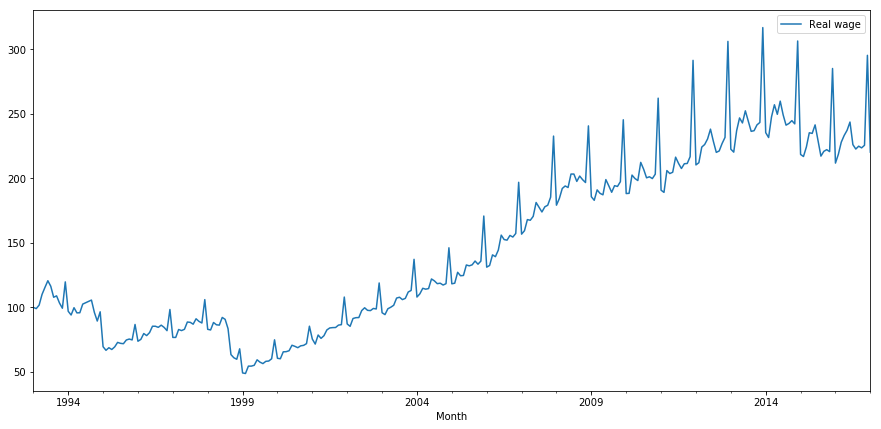

In [ ]:
wage = pd.read_csv('./data/monthly-wage.csv', sep=';', decimal='.', index_col= 0, parse_dates=True, dayfirst=True)
wage.plot(figsize=(15,7))

**Questions** 
    - Which charachteristic of TS can you mention so far?
    - Which components of TS can you see?

$$  SSE =\sum_{t=1}^T  \left({A_t-F_t}\right)^2 $$
$$  MSE =\frac{1}{T}\sum_{t=1}^T  \left({A_t-F_t}\right)^2 $$
$$  RMSE =\sqrt{\frac{1}{T}\sum_{t=1}^T  \left({A_t-F_t}{A_t}\right)} $$
$$  MAE =\frac{100}{T}\sum_{t=1}^T  \left|{A_t-F_t}\right| $$
$$  MAPE =\frac{1}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t}\right| $$
$$  MACAPE =\frac{2}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t+F_t}\right| $$
$$  MedianAE = Median \bigl(\left|A_1-F_1\right|,\dots,\left|A_T-F_T\right|\bigr) $$

In [ ]:
# Quality functions
def qualitySSE(x,y):
    # Sum squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).sum(), (x-y)**2

def qualityMSE(x,y):
    # Mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).mean() , (x-y)**2

def qualityRMSE(x,y):
    # Root mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (((x-y)**2).mean())**(0.5) , (x-y)**2

def qualityMAE(x,y):
    # Mean absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (x-y).abs().mean(), (x-y).abs()

def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityMACAPE(x,y):
    # Mean average corrected absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityMedianAE(x,y):
    # Median absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y).abs()).median(), (x-y).abs()

<h1 align="center"> Simple Exponential  </h1> </h1>

<h1 align="center">Practice: Realization of Holt and Winters Methods </h1>

# SES to Mothly Wage Data
You need to apply IES model for TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.


 *  0) Forecast Wage TS with SES $\alpha=.1$.
 * 1) Find the best param $\alpha$ of SES for data period from 09.1998 to 01.2015. Is the optimal value close to 0 or 1? (You 
can choose any loss function above).
 * 2) Draw forecast with optimial value $\alpha$ for data from 09.1998 to 01.2017. 
      Conclude whether SES can be used for this TS? If can not than explain why.

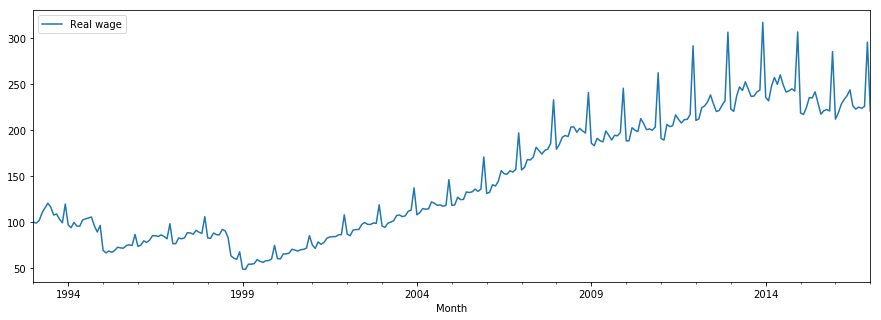

In [ ]:
# draw Wage TS ones more
wage.plot(figsize=(15,5))

## 0) forecast Wage TS with SES alpha =0.1

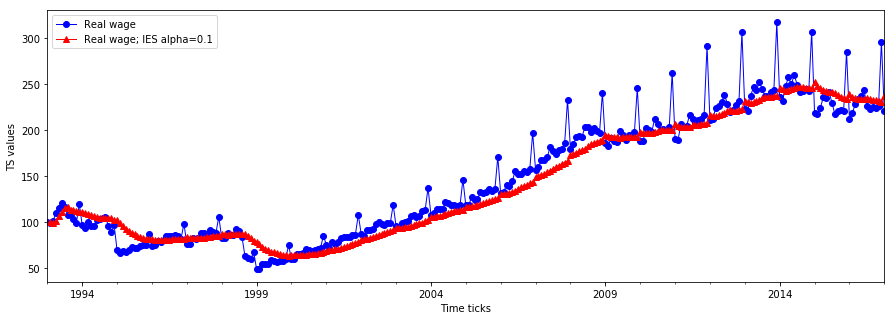

In [ ]:
ESParamsArray = [{'alpha':0.1, 'AdaptationPeriod':10}]
FRC_WAGE = build_forecast(h=1, ts=wage, AlgName =  'InitExponentialSmoothing', AlgTitle='IES' ,ParamsArray = ESParamsArray)

plotTSForecast(wage.loc['1993-01-01':'2017-01-01'], FRC_WAGE[list(FRC_WAGE)[0]].loc['1993-01-01':'2017-01-01']
               , ts_num=0, alg_title='IES alpha=0.1')

## 1) Search for the optimal $\alpha$ 

In [ ]:
ALPHA = np.linspace(0.01,0.99,99)
ESParamsArray = [{'alpha':alpha, 'AdaptationPeriod':10} for alpha in ALPHA]
FRC_WAGE = build_forecast(h=1, ts=wage, AlgName =  'InitExponentialSmoothing', AlgTitle='IES' ,ParamsArray = ESParamsArray)

In [ ]:
# compare ES parameters
QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_WAGE.keys())

ix = wage.loc['1998-09-01':'2015-01-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE[param_cntr]
    QualityStr[param_cntr],_ = qualityMACAPE(wage.loc[ix], frc_wage.loc[ix])

QualityStr[QualityStr.columns].mean().sort_values()

IES {'alpha': 0.41000000000000003, 'AdaptationPeriod': 10}     0.058955
IES {'alpha': 0.42000000000000004, 'AdaptationPeriod': 10}     0.058957
IES {'alpha': 0.40000000000000002, 'AdaptationPeriod': 10}     0.058959
IES {'alpha': 0.42999999999999999, 'AdaptationPeriod': 10}     0.058967
IES {'alpha': 0.39000000000000001, 'AdaptationPeriod': 10}     0.058974
IES {'alpha': 0.38, 'AdaptationPeriod': 10}                    0.058998
IES {'alpha': 0.44, 'AdaptationPeriod': 10}                    0.058998
IES {'alpha': 0.37, 'AdaptationPeriod': 10}                    0.059048
IES {'alpha': 0.45000000000000001, 'AdaptationPeriod': 10}     0.059093
IES {'alpha': 0.36000000000000004, 'AdaptationPeriod': 10}     0.059127
IES {'alpha': 0.46000000000000002, 'AdaptationPeriod': 10}     0.059193
IES {'alpha': 0.35000000000000003, 'AdaptationPeriod': 10}     0.059271
IES {'alpha': 0.47000000000000003, 'AdaptationPeriod': 10}     0.059305
IES {'alpha': 0.48000000000000004, 'AdaptationPeriod': 10}     0

** Question**
  * Is optimal alpha less than 0.3?

## 2) draw the forecast with optimial value $\alpha $

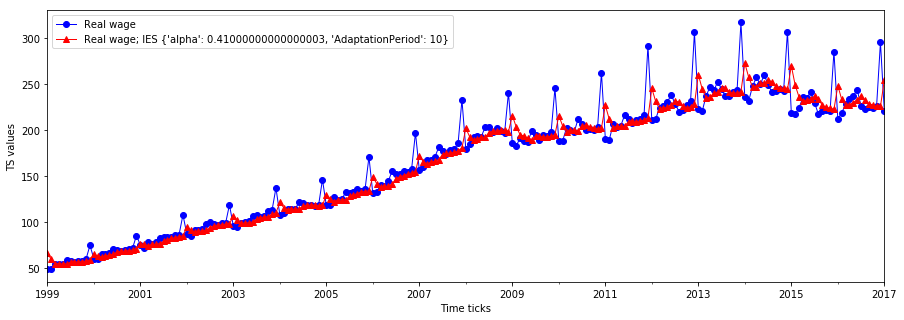

In [ ]:
algName = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage.loc['1999-01-01':'2017-01-01'], FRC_WAGE[algName].loc['1999-01-01':'2017-01-01']
               , ts_num=0, alg_title=algName)

** Question**
    * Does SES follow to the TS components?

## 3) Calculate loss of the forecast of TS in [02.2016, 01.2017]

In [ ]:
qualityMACAPE(wage.loc['2016-02-01':'2017-01-01'], FRC_WAGE[algName].loc['2016-02-01':'2017-01-01'])[0]

Real wage    0.058628
dtype: float64

# SES to Yearly Wage Data
## 0) Aggregate original TS by Years

In [ ]:
wage_year = wage.resample("12MS").sum()[:-1] # cut 2017 year
wage_year[-4:]

Real wage
Month                
2013-01-01     2940.9
2014-01-01     3007.2
2015-01-01     2766.7
2016-01-01     2790.6

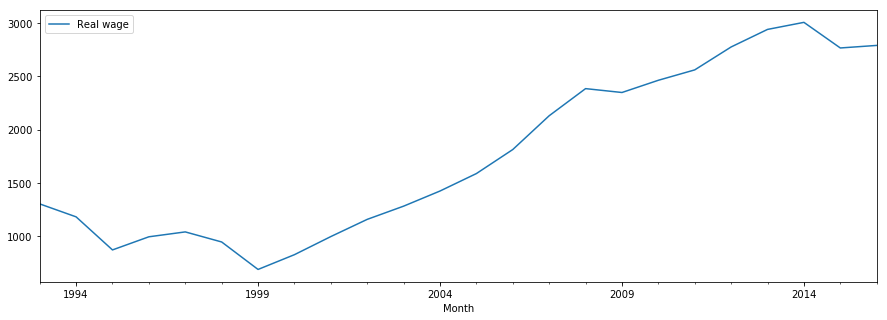

In [ ]:
wage_year.plot(figsize=(15,5))

## Search of optimal $\alpha$ for aggregated data

In [ ]:
ALPHA = np.linspace(0.01,1,100)
ESParamsArray = [{'alpha':alpha, 'AdaptationPeriod':10} for alpha in ALPHA]
FRC_WAGE_YEAR = build_forecast(h=1, ts=wage_year, AlgName =  'InitExponentialSmoothing', AlgTitle='IES'
                              ,ParamsArray = ESParamsArray, step='12MS')

In [ ]:
# compare ES parameters
QualityStr = pd.DataFrame(index = wage_year.columns, columns = FRC_WAGE_YEAR.keys())

ix = wage_year.loc['1999-01':'2010-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_YEAR[param_cntr]
    QualityStr[param_cntr],_ = qualityMACAPE(wage_year.loc[ix], frc_wage.loc[ix])

QualityStr[QualityStr.columns].mean().sort_values()[:5]

IES {'alpha': 1.0, 'AdaptationPeriod': 10}                    0.113797
IES {'alpha': 0.98999999999999999, 'AdaptationPeriod': 10}    0.114357
IES {'alpha': 0.97999999999999998, 'AdaptationPeriod': 10}    0.114926
IES {'alpha': 0.96999999999999997, 'AdaptationPeriod': 10}    0.115505
IES {'alpha': 0.96000000000000008, 'AdaptationPeriod': 10}    0.116093
dtype: float64

## Forecast with optimial value  $\alpha$ and loss MACAPE

MACAPE: Real wage    0.045954
dtype: float64


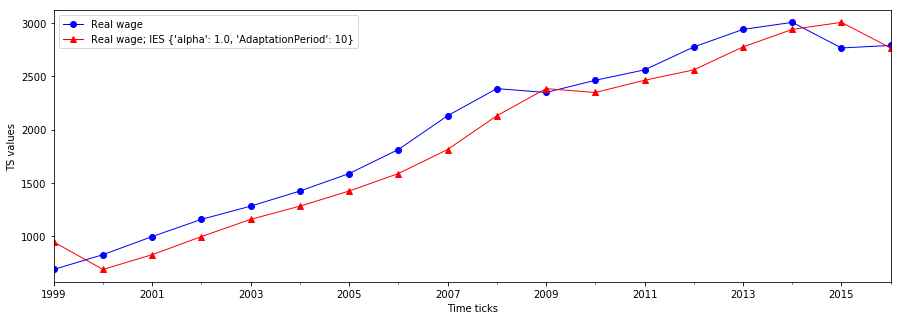

In [ ]:
algName = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage_year.loc['1999-01-01':'2016-01-01'], FRC_WAGE_YEAR[algName].loc['1999-01-01':'2016-01-01']
               , ts_num=0, alg_title=algName)

print('MACAPE: %s' % qualityMACAPE(wage_year.loc['2015-01-01':'2016-01-01'], FRC_WAGE_YEAR[algName].loc['2015-01-01':'2016-01-01'])[0])

# New Section

# Realize Holt model for Yearly Wage TS
You need to realize Holt model and then use it for forecasting real TS.

* 1) Realize Theil-Wage model
* 2) Find optimal params $\alpha$ (smoothing of level), $\beta$ (smoothing trend) (the forecast horizon is equal to 1)
* 3) Draw forecast with optimal values $\alpha$, $\beta$ from 1998 to 2016. 
* 4) Make conclusion about Holt models for this TS 

In [ ]:
###################### Holt Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    beta <scalar in [0,1]> - linear trend smoothing parameter
#    
def HoltExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    AdaptationPeriod = Params['AdaptationPeriod']
    
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    if beta>1:
        w.warn('beta can not be more than 1')
        #beta = 1
        return FORECAST
    if beta<0:
        w.warn('beta can not be less than 0')
        #beta = 0
        return FORECAST
    
    
    l= np.NaN
    b= np.NaN
    
    for t in range(T):
        if not math.isnan(x[t]):
            if math.isnan(l):
                l = x[t]
                b = x[t+1]-x[t]
                t0 = np.NaN
                
            l_prev = l    
                        
            if (t-t0+1)<AdaptationPeriod:
                l = (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))* x[t] + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*(l+b)
                b = (1-beta)*(t-t0+1)/(AdaptationPeriod)*(l - l_prev) + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*b
            else:
                l = alpha* x[t] + (1-alpha)*(l+b)
                b = beta* (x[t] - l_prev) + (1- beta)*b
                
        FORECAST[t+h] = l+ b*h
    return FORECAST

In [ ]:
ALPHA = np.linspace(0.1,1,10)
BETA = np.linspace(0.1,1,10)
HoltParamsArray = [{'alpha':alpha, 'beta':beta, 'AdaptationPeriod':5} for alpha in ALPHA for beta in BETA]
FRC_WAGE_YEAR = build_forecast(h=1, ts=wage_year.loc['1999-01':'2016-01'], AlgName =  'HoltExponentialSmoothing', AlgTitle='Holt'
                              ,ParamsArray = HoltParamsArray, step='12MS')

QualityStr = pd.DataFrame(index = wage_year.columns, columns = FRC_WAGE_YEAR.keys())
ix = wage_year.loc['1999-01':'2014-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_YEAR[param_cntr]
    QualityStr[param_cntr],_ = qualityMACAPE(wage_year.loc[ix], frc_wage.loc[ix])

QualityStr[QualityStr.columns].mean().sort_values()[:5]

Holt {'alpha': 1.0, 'beta': 0.10000000000000001, 'AdaptationPeriod': 5}                    0.031630
Holt {'alpha': 0.90000000000000002, 'beta': 0.10000000000000001, 'AdaptationPeriod': 5}    0.032250
Holt {'alpha': 1.0, 'beta': 0.20000000000000001, 'AdaptationPeriod': 5}                    0.033420
Holt {'alpha': 1.0, 'beta': 0.30000000000000004, 'AdaptationPeriod': 5}                    0.034291
Holt {'alpha': 0.90000000000000002, 'beta': 0.20000000000000001, 'AdaptationPeriod': 5}    0.034495
dtype: float64

## Draw Forecast

MACAPE: Real wage    0.035925
dtype: float64


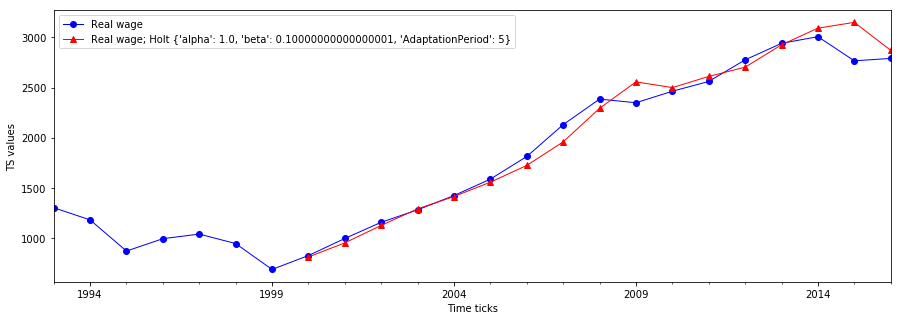

In [ ]:
algName = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage_year, FRC_WAGE_YEAR[algName].loc['1999-01-01':'2016-01-01']
               , ts_num=0, alg_title=algName)

print('MACAPE: %s' % qualityMACAPE(wage_year.loc['2010-01-01':'2016-01-01'], FRC_WAGE_YEAR[algName].loc['2010-01-01':'2016-01-01'])[0])

** Questions**
   - Is Optimal $\beta$ less than 0.3?
   - Why the optimal $\alpha$ is close to 1 for this TS?
   - Does Forecast of Hold model looks more appropriate than the forecast of SES model?

# Materials
* Лукишн Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.